In [41]:
from utils import TickerDataGenerator
from os import listdir
from random import sample
from typing import *
import sys
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

In [31]:
def _is_colab() -> bool:
    return 'google.colab' in sys.modules

def mount_drive():
    if _is_colab():
        from google.colab import drive
        drive.mount("/content/gdrive")

def choose_tickers(PATH: str, num_tickers: int) -> List:
    files = listdir(PATH)
    return [x.replace(".csv", "") for x in sample(files, num_tickers)]

def fit_scaler(scaler: MinMaxScaler, 
               X_train: np.ndarray, 
               y_train: np.ndarray, 
               X_test: list, 
               y_test: list):
    #we want the scaler to handle all sorts of price action, high volatility to low...so fit all together
    data_to_scale = np.concatenate([X_train.flatten(), 
                                    y_train.flatten(), 
                                    np.array(X_test).flatten(), 
                                    np.array(y_test).flatten()]).reshape(-1,1)
    scaler.fit(data_to_scale)


In [ ]:
mount_drive()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
PATH = "gdrive/MyDrive/PriceData/PriceData"
TICKER_LIST = choose_tickers(PATH, 20)
FEATURES = ["close", "high", "low"]
LABEL = "close"
SPLIT_PERC = 0.2
PERIOD = 20

data_gen = TickerDataGenerator(TICKER_LIST, PATH)

X_train, y_train, X_test, y_test = data_gen.create_train_data(feature_cols = FEATURES, 
                                                              label_col = LABEL,
                                                              split_perc=SPLIT_PERC,
                                                              period=PERIOD,
                                                              as_pct_change=True, 
                                                              as_cumsum=True)
print(f"""
Num Train samples: {X_train.shape[0]}
Num Test samples: {sum([x.shape[0] for x in X_test])}
""")



Num Train samples: 17400
Num Test samples: 4340



In [32]:
scaler = MinMaxScaler(feature_range=(-1, 1))
fit_scaler(scaler, X_train, y_train, X_test, y_test)

X_train = np.array([scaler.transform(x) for x in X_train])
y_train = np.array([scaler.transform(y.reshape(-1,1)) for y in y_train])
X_test =  [np.array([scaler.transform(x) for x in ticker]) for ticker in X_test]

In [33]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = [torch.from_numpy(x).type(torch.Tensor) for x in X_test]
y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1,1)

In [36]:
INPUT_DIM = X_train.size(-1)
NUM_LAYERS = 2
OUTPUT_DIM = y_train.size(-1)
NUM_EPOCHS = 60

In [35]:
class PricePredictionGRU(nn.Module):
    def __init__(self, input_dim, num_layers, output_dim):
        super(PricePredictionGRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.GRU = nn.GRU(input_dim, 
                          32, 
                          num_layers, 
                          batch_first=True)
        self.dense1 = nn.Linear(32, 8)
        self.dense2 = nn.Linear(8, output_dim)

    def forward(self, X):
        hidden_0 = torch.zeros(self.num_layers, X.size(0), 32).requires_grad_()
        out, _ = self.GRU(X, hidden_0)
        out = self.dense2(self.dense1(out[:, -1, :]))
        return out

model = PricePredictionGRU(INPUT_DIM, NUM_LAYERS, OUTPUT_DIM)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [39]:
def train_model():
    hist = np.zeros(NUM_EPOCHS)
    start_time = time.time()
    for e in range(NUM_EPOCHS):
        optimizer.zero_grad()
        yhat = model(X_train)
        loss = criterion(yhat, y_train)
        print(f"Epoch: {e} || MSE: {loss.item()}\n")
        hist[e] = loss.item()
        loss.backward()
        optimizer.step()

    print(f"Total Time Elapsed: {time.time()-start_time}")
    return hist

hist = train_model()

Epoch: 0 || MSE: 0.062314145267009735

Epoch: 1 || MSE: 0.011226474307477474

Epoch: 2 || MSE: 0.02784179523587227

Epoch: 3 || MSE: 0.014062924310564995

Epoch: 4 || MSE: 0.011587558314204216

Epoch: 5 || MSE: 0.015950007364153862

Epoch: 6 || MSE: 0.016888661310076714

Epoch: 7 || MSE: 0.014162237755954266

Epoch: 8 || MSE: 0.010730552487075329

Epoch: 9 || MSE: 0.008860276080667973

Epoch: 10 || MSE: 0.009267457760870457

Epoch: 11 || MSE: 0.010340503416955471

Epoch: 12 || MSE: 0.009582153521478176

Epoch: 13 || MSE: 0.0073431204073131084

Epoch: 14 || MSE: 0.00582084059715271

Epoch: 15 || MSE: 0.005733644124120474

Epoch: 16 || MSE: 0.005709415301680565

Epoch: 17 || MSE: 0.00430557643994689

Epoch: 18 || MSE: 0.0020510924514383078

Epoch: 19 || MSE: 0.0013888420071452856

Epoch: 20 || MSE: 0.002311109099537134

Epoch: 21 || MSE: 0.0009046973427757621

Epoch: 22 || MSE: 0.0009050806402228773

Epoch: 23 || MSE: 0.0026577177923172712

Epoch: 24 || MSE: 0.0015085255727171898

Epoch:

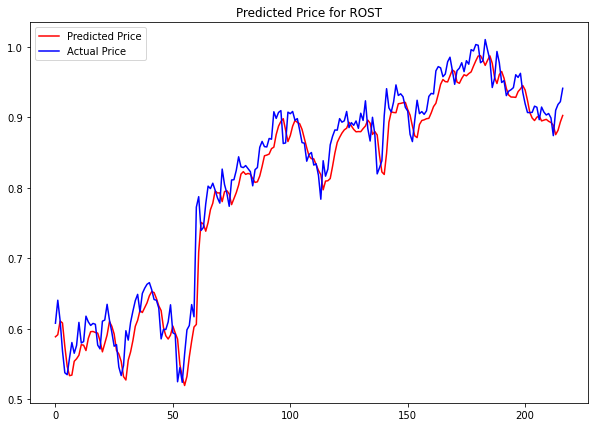

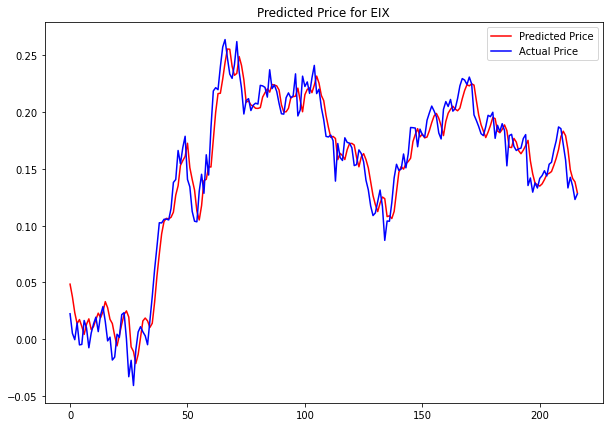

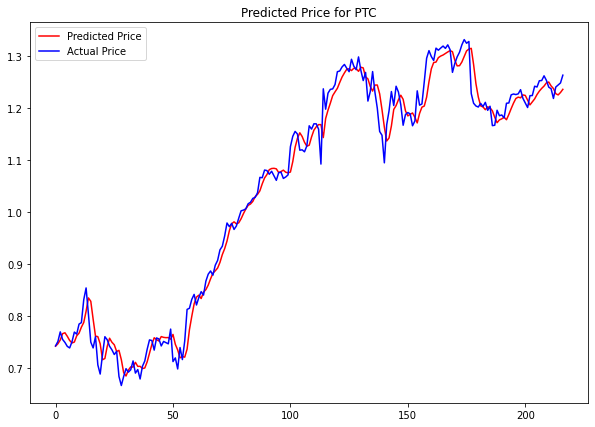

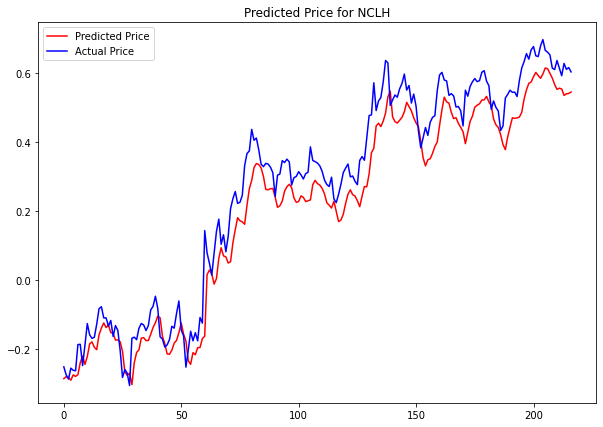

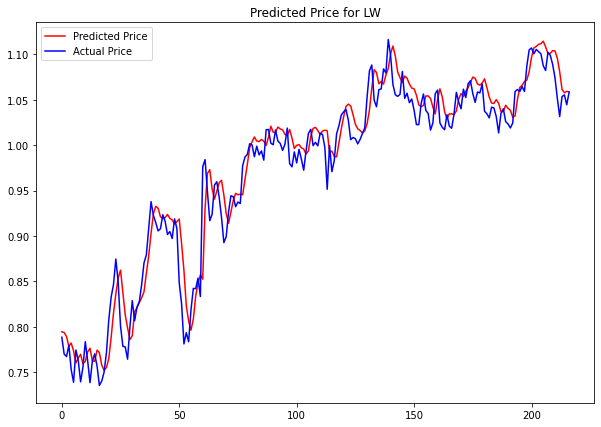

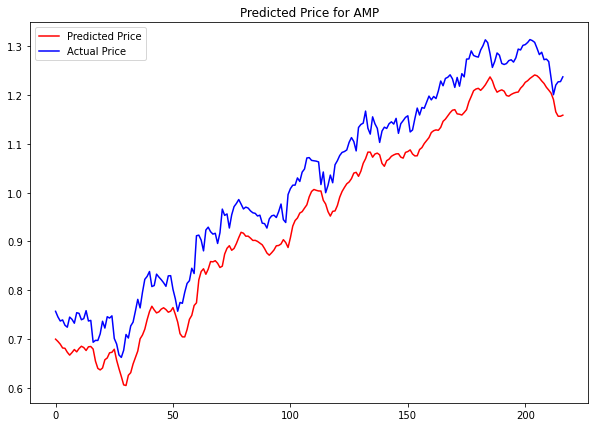

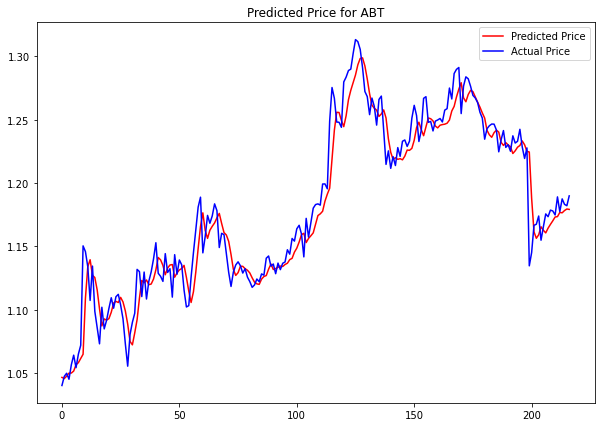

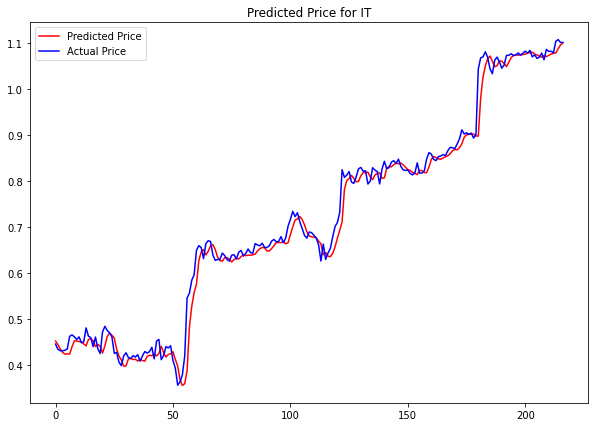

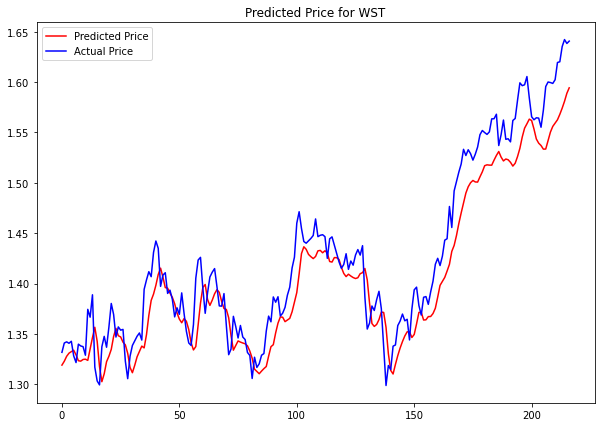

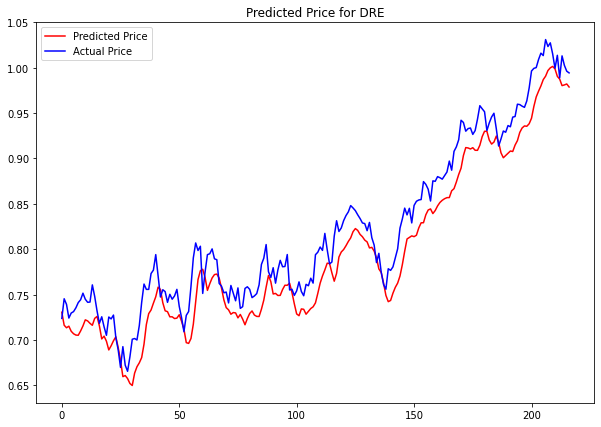

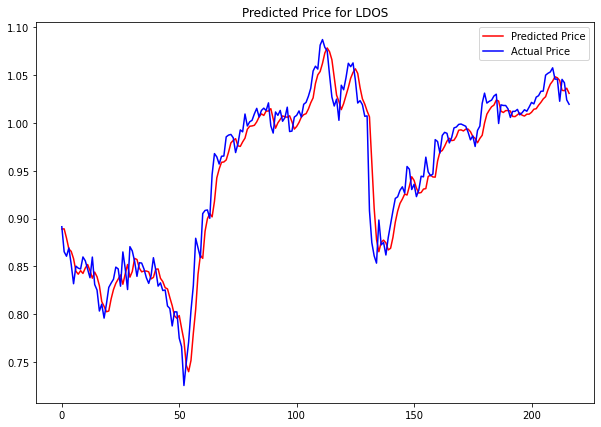

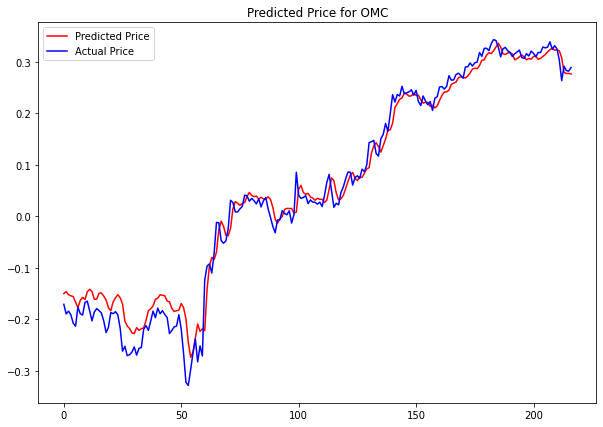

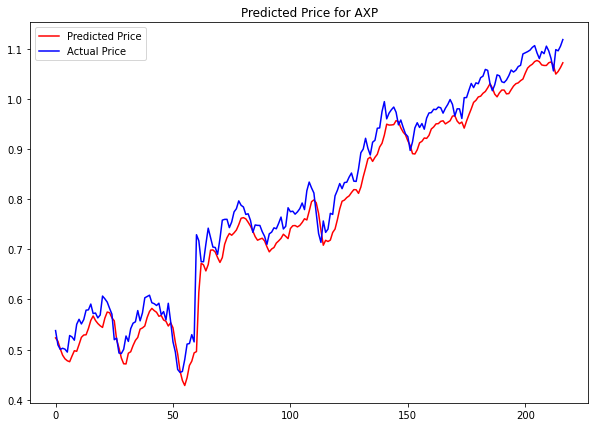

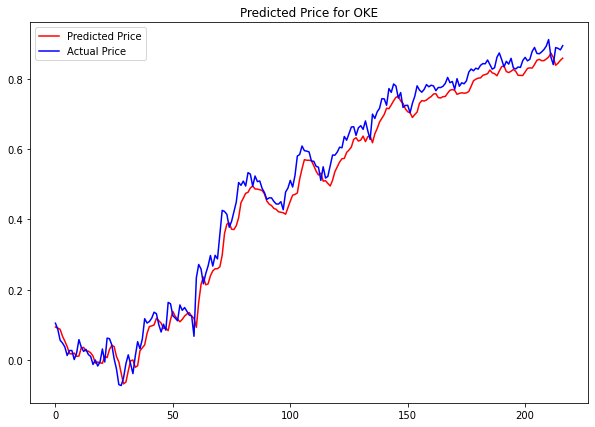

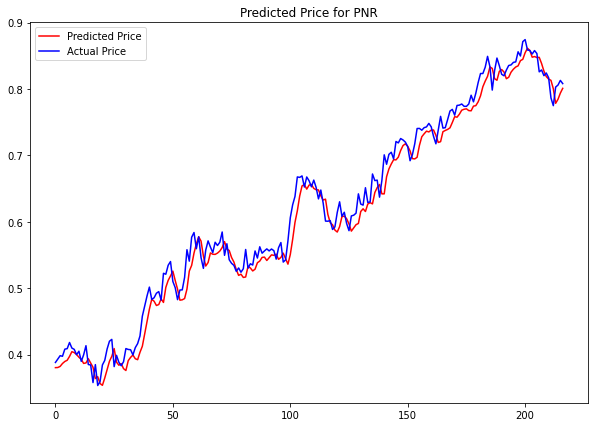

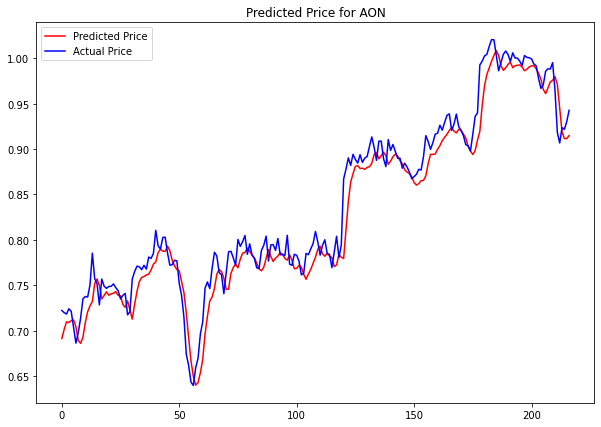

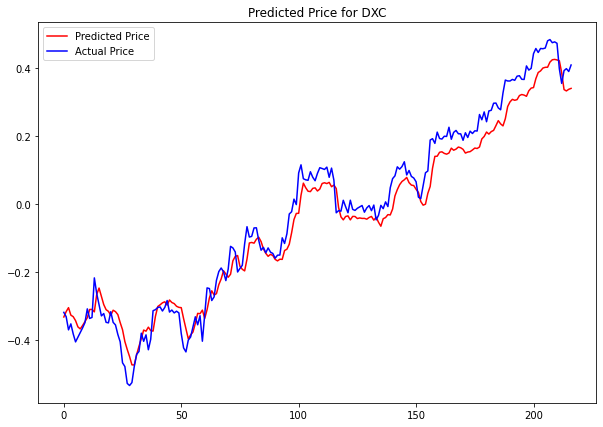

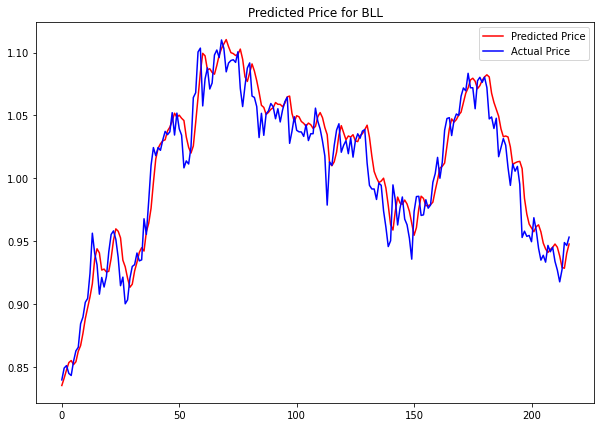

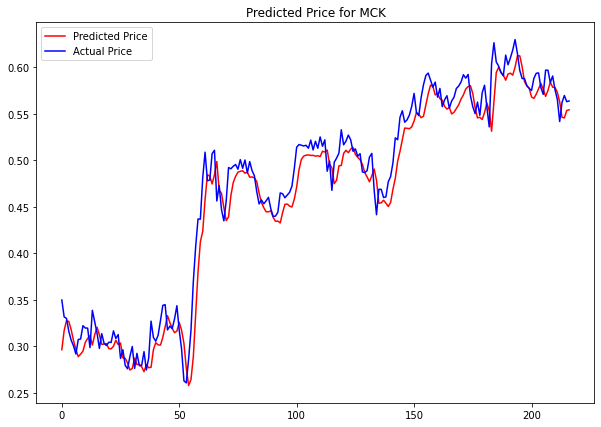

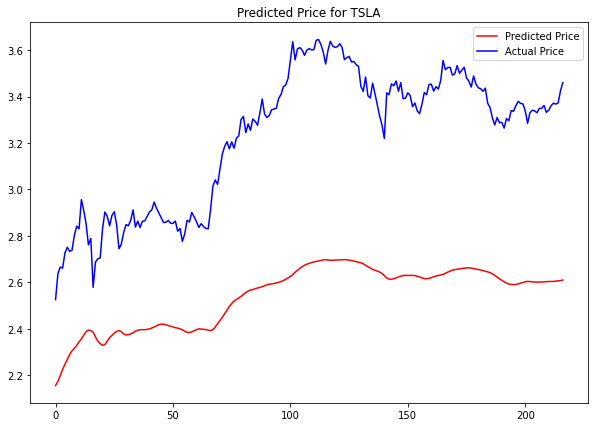

In [42]:
for idx in range(len(TICKER_LIST)):
    ticker = TICKER_LIST[idx]

    ticker_test = X_test[idx]

    ticker_yhat = model(ticker_test)
    ticker_yhat = scaler.inverse_transform(ticker_yhat.detach())
    ticker_y = y_test[idx]

    #Plot Predicted vs Acutal
    plt.figure(figsize=(10,7))
    plt.plot(ticker_yhat, c="red", label="Predicted Price")
    plt.plot(ticker_y, c="blue", label="Actual Price")
    plt.legend()
    plt.title(f"Predicted Price for {ticker}")
    plt.show()

